# Автоэнкодеры в Keras


# Часть 6: VAE + GAN

### Содержание

* Часть 1: Введение
* Часть 2: *Manifold learning* и скрытые (*latent*) переменные
* Часть 3: Вариационные автоэнкодеры (*VAE*)
* Часть 4: *Conditional VAE*
* Часть 5: *GAN* (Generative Adversarial Networks) и tensorflow
* **Часть 6: *VAE* + *GAN* **



В позапрошлой части мы создали ***CVAE*** автоэнкодер, декодер которого умеет генерировать цифру заданного лейбла, мы также попробовали создавать картинки цифр других лейблов в стиле заданной картинки. Получилось довольно хорошо, однако цифры генерировались смазанными.  
В прошлой части мы изучили как работают ***GAN'ы***, получив довольно четкие изображения цифр, однако пропала возможность кодирования и переноса стиля.

В этой части попробуем взять лучшее от обоих подходов путем совмещения *вариационных автоэнкодеров* (***VAE***) и *генеративных состязающихся сетей* (***GAN***). 

Подход который будет описан далее основан на статье ***[Autoencoding beyond pixels using a learned similarity metric, Larsen et al, 2016]***.

#### Разберемся более подробно почему восстановленные изображения получаются смазанные.  
В части про *VAE* рассматривался процесс генерации изображений $X$ из скрытых (*latent*) переменных $Z$.   
Так как размерность скрытых переменных $Z$ значительно ниже, чем размерность объектов $X$ (в части про *VAE* эти размерности были 2 и 784), то одному и тому же $Z$ может соответствовать многомерное распределение $X$, то есть $P(X|Z)$. Это распределение можно представить как:

$$
P(X|Z) = f(Z) + \epsilon,
$$

где $f(Z)$ некоторый средний наиболее вероятный объект при заданном $Z$, а $\epsilon$ - шум какой-то сложной природы.

Когда мы обучаем автоэнкодеры, мы сравниваем вход из выборки $X_s$ и выход автоэнкодера $\tilde X_s$ с помощью некоторого функционала ошибки $L$,

$$
L(X_s, \tilde X_s), \\
\tilde X_s = f_d(Z; \theta_d), \\
Z \sim Q(Z|X_s; \theta_e),
$$

где $Q,\ f_d$ - энкодер и декодер.

Задавая $L$ - мы определяем шум $\epsilon_L$, которым приближаем настоящий шум $\epsilon$.  
Минимизируя $L$ мы учим автоэнкодер подстраиваться под шум $\epsilon_L$, убирая его, то есть находить среднее значение в заданной метрике (во второй части это показывалось наглядно на простом искусственном примере).

Если шум $\epsilon_L$, который мы определеям функционалом $L$ не соответствует рельному шуму $\epsilon$, то $f_d(Z; \theta_2)$ окажется сильно смещеным от реального $f(Z)$ (пример: если в регрессии реальный шум лаплассовский, а минимизируется разность квадратов, то предсказанное значение будет смещено в сторону выбросов). 

Возвращаясь к картинкам: посмотрим как связана попиксельная метрика которой определен лосс в предыдущих частях, и метрика используемая человеком. Пример и иллюстрация из ***[2]***  

![](figs6/metric.png)

На картинке выше: (а) - оригинальное изображение цифры, (b) - получена из (а) отрезанием куска, (с) - цифра (а) сдвинутая на пол пикселя вправо.  
С точки зрения попиксельной метрики: (а) намного ближе к (b), чем к (с);  
хотя с точки зрения человеческого восприятия (b) - даже не цифра, а вот разница между (а) и (b) практически незаметна.

Автоэнкодеры с попиксельной метрикой таким образом размазывали изображение, отражая тот факт, что 
в рамках близких $Z$:  
- положение цифр слегка гуляет по картинке,  
- нарисованы цифры слегка поразному (хотя попиксельно может быть значительно далеко).

По метрике же человеческого восприятия, тот факт, что цифра размылась уже заставляет ее быть сильно не похожей на оригинал. Таким образом если мы будем знать метрику человека или близкую к ней и оптимизировать в ней, то цифры не будут размываться, а важность того, чтобы цифра была полноценной, не как с картинки (b), резко возрастет.

Можно пытаться вручную придумывать метрику, которая будет ближе к человеческой. Но используя подход ***GAN*** можно обучить нейронную сеть самой искать хорошую метрику.

Про *GAN'ы* написано в прошлой части.

### Соединяя *VAE* и *GAN*

Генератор *GAN* выполняет функцию аналогичную декодеру в *VAE*: оба сэмплят из априорного распределения $P(Z)$ и переводят его в $P_g(X)$. Однако роли у них разные: декодер восстанавливает объект закодированный энкодером, при обучении опираясь на некоторую метрику сравнения; генератор же генерирует случайный объект, который ни с чем не сравнивается, лишь бы дискриминатор не мог отличить какому из распределений $P$ или $P_g$ он принадлежит.

Идея: добавить в *VAE* третью сеть - дискриминатор, и подавать ей на вход и восстановленный объект и оригинал, а дискриминатор обучать определять какой из них какой.
![](figs6/VAE_GAN_scheme.png)

Иллюстрация из ***[1]***

Разумеется использовать ту же самую метрику сравнения из *VAE* мы уже не можем, потому что обучаясь в ней декодер генерирует изображения легко отличимые от оригинала. Не использовать метрику вообще - тоже, так как нам бы хотелось, чтобы воссозданный $\hat X$ был похож на оригинал, а не просто какой-то случайный из $P(X)$, как в чистом *GAN*.

Задумаемся, однако, вот о чем: дискриминатор, учась отличать реальный объект от сгенерированного, будет вычлинять какие-то характерные черты одних и других. Эти черты объекта будут закодированы в слоях дискриминатора и на основе их комбинации он уже будет выдавать вероятность объекта быть реальным. Например, если изображение размыто, то какой-то нейрон в дискриминаторе будет активироваться сильнее, чем если оно четкое. При этом чем глубже слой, тем более абстрактные характеристики входного объекта в нем закодированы.

Так как каждый слой дискриминатора является кодом-описанием объекта, и при этом кодирует черты, позволяющие дискриминатору отличать сгенерированные объекты от реальных, то можно заменить какую-то простую метрику (например, попиксельную), на метрику над активациями нейронов в каком-то из слоев:

$$
L(X_s, \tilde X_s) \longrightarrow L_d(d_l(X_s), d_l(\tilde X_s)) \\
\tilde X_s = f_d(Z; \theta_d), \\
Z \sim Q(X_s; \theta_e),
$$

где $d_l$ - активации на $l$-ом слое дискриминатора, а $Q, \ f_d$ - энкодер и декодер.

При этом можно надеяться, что новая метрика $L_d$ будет лучше.

Ниже приведена схема работы получившейся *VAE+GAN* сети, предлагаемая авторами ***[1]***.  
Иллюстрация из ***[1]***  

![](figs6/VAE_GAN_losses.png)

Здесь:

- $X$ - входной объект из $P(X)$,
- $Z_p$ - сэмплированный $Z$ из $P(Z)$,
- $X_p$ - объект сгенерированный декодером из $Z_p$,
- $\tilde X$ - объект восстановленный из $X$,
- $\mathcal L_{prior} = KL \left[ Q(Z|X)||P(Z) \right]$ - лосс, заставляющий энкодер переводить $P(X)$ в нужное нам $P(Z)$ (точно как в части 3 про *VAE*),
- $\mathcal L_{llike}^{Dis_l} = L_d(d_l(X), d_l(\tilde X))$ - метрика между активациями $l$-ого слоя дискриминатора $D$ на реальном $X$ и восстановленным $\tilde X = f_d(Q(X))$,
- $\mathcal L_{GAN} = \log(D(X)) + \log(1 - D(f_d(Z))) + \log(1 - D(f_d(Q(X))))$ - кросс-энтропия между реальным распределением лейблов настоящих/сгенерированных объектов, и распределением вероятности предсказываемым дискриминатором.

Как и в случае с *GAN* мы не можем обучать все 3 части сети одновременно. Дискриминатор надо обучать отдельно, в частности не нужно, чтобы дискриминатор пытался уменьшать $\mathcal L_{llike}^{Dis_l}$, так как это схлопнет разницу активаций в 0. Поэтому обучение всех сетей надо ограничить только на релевантные им лоссы.  

Схема предлагаемая авторами:

$$
\theta_{Enc} = \theta_{Enc} - \Delta_{\theta_{Enc}} (\mathcal L_{prior} + \mathcal L^{Dis_l}_{llike}), \\
\theta_{Dec} = \theta_{Dec} - \Delta_{\theta_{Dec}} (\gamma \mathcal L^{Dis_l}_{llike} - \mathcal L_{GAN}), \\
\theta_{Dis} = \theta_{Dis} - \Delta_{\theta_{Dis}} (\mathcal L_{GAN})
$$

Выше видно на каких лоссах какие сети учатся. Особое внимание разве что стоит уделить декодеру: он с одной стороны пытается уменьшить расстояние между входом и выходом в метрике *l-го* слоя дискриминатора ($\mathcal L^{Dis_l}_{llike}$), а с другой пытается обмануть дискриминатор (увеличивая $\mathcal L_{GAN}$). В статье авторы утверждают, что меняя коэффициент $\gamma$ можно влиять на то, что важнее для сети: контент ($\mathcal L^{Dis_l}_{llike}$) или стиль ($\mathcal L_{GAN}$). Не могу, однако, сказать, что наблюдал этот эффект.

## Код

Код во многом повторяет то, что было в прошлых частях про чистые ***VAE*** и ***GAN***.

Опять же сразу будем писать **conditional** модель

Почти полное повторение того, что было в части про *GAN*

In [1]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.layers import Dropout, BatchNormalization, Reshape, Flatten, RepeatVector
from keras.layers import Lambda, Dense, Input, Conv2D, MaxPool2D, UpSampling2D, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation
from keras.models import Model, load_model


# Регистрация сессии в keras
from keras import backend as K
import tensorflow as tf
sess = tf.Session()
K.set_session(sess)


# Импорт датаеста
from keras.datasets import mnist
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)


# Глобальные константы
batch_size = 64
batch_shape = (batch_size, 28, 28, 1)
latent_dim = 8
num_classes = 10
dropout_rate = 0.3
gamma = 1 # Коэффициент гамма


# Итераторы тренировочных и тестовых батчей
def gen_batch(x, y):
    n_batches = x.shape[0] // batch_size
    while(True):
        idxs = np.random.permutation(y.shape[0])
        x = x[idxs]
        y = y[idxs]
        for i in range(n_batches):
            yield x[batch_size*i: batch_size*(i+1)], y[batch_size*i: batch_size*(i+1)]

train_batches_it = gen_batch(x_train, y_train_cat)
test_batches_it  = gen_batch(x_test,  y_test_cat)


# Входные плейсхолдеры
x_ = tf.placeholder(tf.float32, shape=(None, 28, 28, 1),  name='image')
y_ = tf.placeholder(tf.float32, shape=(None, 10),         name='labels')
z_ = tf.placeholder(tf.float32, shape=(None, latent_dim), name='z')

img = Input(tensor=x_)
lbl = Input(tensor=y_)
z   = Input(tensor=z_)

Using TensorFlow backend.


Описание моделей, от *GAN* отличается только добавленным энкодером

In [2]:
def add_units_to_conv2d(conv2, units):
    dim1 = int(conv2.shape[1])
    dim2 = int(conv2.shape[2])
    dimc = int(units.shape[1])
    repeat_n = dim1*dim2
    units_repeat = RepeatVector(repeat_n)(lbl)
    units_repeat = Reshape((dim1, dim2, dimc))(units_repeat)
    return concatenate([conv2, units_repeat])


def apply_bn_relu_and_dropout(x, bn=False, relu=True, dropout=True):
    if bn:
        x = BatchNormalization(momentum=0.99, scale=False)(x)
    if relu:
        x = LeakyReLU()(x)
    if dropout:
        x = Dropout(dropout_rate)(x)
    return x


with tf.variable_scope('encoder'):
    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same')(img)
    x = apply_bn_relu_and_dropout(x)
    x = MaxPool2D((2, 2), padding='same')(x)
#     x = add_units_to_conv2d(x, lbl)

    x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
    x = apply_bn_relu_and_dropout(x)

    x = Flatten()(x)
    x = concatenate([x, lbl])
    
    h = Dense(64)(x)
    h = apply_bn_relu_and_dropout(h)

    z_mean    = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(K.clip(z_log_var/2, -2, 2)) * epsilon
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model([img, lbl], [z_mean, z_log_var, l], name='Encoder')


with tf.variable_scope('decoder'):
    x = concatenate([z, lbl])
    x = Dense(7*7*128)(x)
    x = apply_bn_relu_and_dropout(x)
    x = Reshape((7, 7, 128))(x)
    x = UpSampling2D(size=(2, 2))(x)

    x = Conv2D(64, kernel_size=(5, 5), padding='same')(x)
    x = apply_bn_relu_and_dropout(x)

    x = Conv2D(32, kernel_size=(3, 3), padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = apply_bn_relu_and_dropout(x)
#     x = add_units_to_conv2d(x, lbl)
    
    decoded = Conv2D(1, kernel_size=(5, 5), activation='sigmoid', padding='same')(x)
decoder = Model([z, lbl], decoded, name='Decoder')


with tf.variable_scope('discrim'):
    x = Conv2D(128, kernel_size=(7, 7), strides=(2, 2), padding='same')(img)
    x = MaxPool2D((2, 2), padding='same')(x)
    x = apply_bn_relu_and_dropout(x)
    x = add_units_to_conv2d(x, lbl)

    x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
    x = MaxPool2D((2, 2), padding='same')(x)
    x = apply_bn_relu_and_dropout(x)

    # l-слой на котором будем сравнивать активации
    l = Conv2D(16, kernel_size=(3, 3), padding='same')(x)
    x = apply_bn_relu_and_dropout(x)

    h = Flatten()(x)
    d = Dense(1, activation='sigmoid')(h)
discrim = Model([img, lbl], [d, l], name='Discriminator')

Построение графа вычислений на основе моделей

In [3]:
z_mean, z_log_var, encoded_img = encoder([img, lbl])

decoded_img = decoder([encoded_img, lbl])
decoded_z   = decoder([z,           lbl])

discr_img,     discr_l_img     = discrim([img,         lbl])
discr_dec_img, discr_l_dec_img = discrim([decoded_img, lbl])
discr_dec_z,   discr_l_dec_z   = discrim([decoded_z,   lbl])

cvae_model = Model([img, lbl], decoder([encoded_img, lbl]), name='cvae')
cvae =  cvae_model([img, lbl])

Определение лоссов  
Интересно, что получался лучше результат, если в качестве метрики на активациях слоев брать не *MSE*, а кросс-энтропию

In [4]:
# Базовые лоссы
L_prior = -0.5*tf.reduce_sum(1. + tf.clip_by_value(z_log_var, -2, 2) - tf.square(z_mean) - tf.exp(tf.clip_by_value(z_log_var, -2, 2)))/28/28

log_dis_img     = tf.log(discr_img + 1e-10)
log_dis_dec_z   = tf.log(1. - discr_dec_z + 1e-10)
log_dis_dec_img = tf.log(1. - discr_dec_img + 1e-10)

L_GAN = -1/4*tf.reduce_mean(log_dis_img + 2*log_dis_dec_z + log_dis_dec_img)

L_dis_llike = tf.reduce_sum(tf.square(discr_l_img - discr_l_dec_img))/28/28
# L_dis_llike = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.sigmoid(discr_l_img),
#                                                                     logits=discr_l_dec_img))/28/28


# Лоссы энкодера, декодера, дискриминатора
L_enc = L_dis_llike + L_prior 
L_dec = gamma * L_dis_llike - L_GAN
L_dis = L_GAN


# Определение шагов оптимизатора
optimizer_enc = tf.train.RMSPropOptimizer(0.001)
optimizer_dec = tf.train.RMSPropOptimizer(0.0003)
optimizer_dis = tf.train.RMSPropOptimizer(0.001)

encoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "encoder")
decoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "decoder")
discrim_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discrim")

step_enc = optimizer_enc.minimize(L_enc, var_list=encoder_vars)
step_dec = optimizer_dec.minimize(L_dec, var_list=decoder_vars)
step_dis = optimizer_dis.minimize(L_dis, var_list=discrim_vars)


def step(image, label, zp):
    l_prior, dec_image, l_dis_llike, l_gan, _, _ = sess.run([L_prior, decoded_z, L_dis_llike, L_GAN, step_enc, step_dec],
                                                            feed_dict={z:zp, img:image, lbl:label, K.learning_phase():1})
    return l_prior, dec_image, l_dis_llike, l_gan

def step_d(image, label, zp):
    l_gan, _ = sess.run([L_GAN, step_dis], feed_dict={z:zp, img:image, lbl:label, K.learning_phase():1})
    return l_gan


Функции рисования картинок после и в процессе тренировки (скрыто)

In [5]:
digit_size = 28
def plot_digits(*args, invert_colors=False):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors:
        figure = 1-figure

    plt.figure(figsize=(2*n, 2*len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()


# Массивы в которые будем сохранять результаты, для последующей визуализации
figs = [[] for x in range(num_classes)]
periods = []

save_periods = list(range(100)) + list(range(100, 1000, 10))

n = 15 # Картинка с 15x15 цифр
from scipy.stats import norm
# Так как сэмплируем из N(0, I), то сетку узлов, в которых генерируем цифры берем из обратной функции распределения
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
def draw_manifold(label, show=True):
    # Рисование цифр из многообразия
    figure = np.zeros((digit_size * n, digit_size * n))
    input_lbl = np.zeros((1, 10))
    input_lbl[0, label] = 1
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim))
            z_sample[:, :2] = np.array([[xi, yi]])

            x_decoded = sess.run(decoded_z, feed_dict={z:z_sample, lbl:input_lbl, K.learning_phase():0})
            digit = x_decoded[0].squeeze()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    if show:
        # Визуализация
        plt.figure(figsize=(15, 15))
        plt.imshow(figure, cmap='Greys')
        plt.grid(False)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.show()
    return figure


# Рисование распределения z
def draw_z_distr(z_predicted):
    im = plt.scatter(z_predicted[:, 0], z_predicted[:, 1])
    im.axes.set_xlim(-5, 5)
    im.axes.set_ylim(-5, 5)
    plt.show()


# Трансфер стиля
def style_transfer(X, lbl_in, lbl_out):
    rows = X.shape[0]
    if isinstance(lbl_in, int):
        label = lbl_in
        lbl_in = np.zeros((rows, 10))
        lbl_in[:, label] = 1
    if isinstance(lbl_out, int):
        label = lbl_out
        lbl_out = np.zeros((rows, 10))
        lbl_out[:, label] = 1
    # Кодирем стиль входящего изображения
    zp = sess.run(z_mean, feed_dict={img:X, lbl:lbl_in, K.learning_phase():0})
    # Восстанавливаем из этого стиля, заменяя лейбл
    created = sess.run(decoded_z, feed_dict={z:zp, lbl:lbl_out, K.learning_phase():0})
    return created


# Картинка трансфера стиля
def draw_random_style_transfer(label):
    n = 10
    generated = []
    idxs = np.random.permutation(y_test.shape[0])
    x_test_permut = x_test[idxs]
    y_test_permut = y_test[idxs]
    prot = x_test_permut[y_test_permut == label][:batch_size]

    for i in range(num_classes):
        generated.append(style_transfer(prot, label, i)[:n])

    generated[label] = prot

    plot_digits(*generated, invert_colors=True)


def on_n_period(period):
    n_compare = 10

    clear_output() # Не захламляем output

    # Сравнение реальных и декодированных цифр
    b = next(test_batches_it)
    decoded = sess.run(cvae, feed_dict={img:b[0], lbl:b[1], K.learning_phase():0})
    plot_digits(b[0][:n_compare], decoded[:n_compare])

    # Рисование многообразия для рандомного y
    draw_lbl = np.random.randint(0, num_classes)    
    print(draw_lbl)
    for label in range(num_classes):
        figs[label].append(draw_manifold(label, show=label==draw_lbl))

    xs = x_test[y_test == draw_lbl]
    ys = y_test_cat[y_test == draw_lbl]
    z_predicted = sess.run(z_mean, feed_dict={img:xs, lbl:ys, K.learning_phase():0})
    draw_z_distr(z_predicted)
    draw_random_style_transfer(7)
    
    periods.append(period)

Процесс обучения

In [ ]:
sess.run(tf.global_variables_initializer())

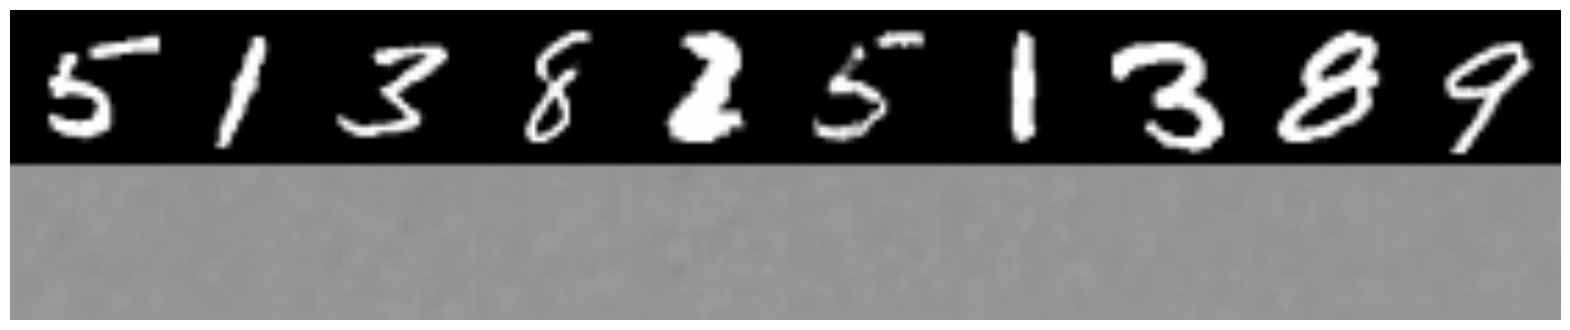

8


In [ ]:
nb_step = 3 # Количество шагов во внутреннем цикле


batches_per_period = 100
for i in range(48000):
    print('.', end='')

    # Шаги обучения дискриминатора
    for j in range(nb_step):
        b0, b1 = next(train_batches_it)
        zp = np.random.randn(batch_size, latent_dim)
        l_g = step_d(b0, b1, zp)
        if l_g < 1.0:
            break
        
    # Шаг обучения декодера и энкодера
    for j in range(nb_step):
        l_p, zx, l_d, l_g = step(b0, b1, zp)
        if l_g > 0.4:
            break
        b0, b1 = next(train_batches_it)
        zp = np.random.randn(batch_size, latent_dim)

    # Периодическая визуализация результата
    if not i % batches_per_period:
        period = i // batches_per_period
        if period in save_periods:
            on_n_period(period)
        print(i, l_p, l_d, l_g)

Функция рисования гифок (скрыто)

Так как у нас снова модель на основе автоэнкодера, мы можем применять перенос стиля

In [ ]:
# Трансфер стиля
def style_transfer(X, lbl_in, lbl_out):
    rows = X.shape[0]
    if isinstance(lbl_in, int):
        label = lbl_in
        lbl_in = np.zeros((rows, 10))
        lbl_in[:, label] = 1
    if isinstance(lbl_out, int):
        label = lbl_out
        lbl_out = np.zeros((rows, 10))
        lbl_out[:, label] = 1
    # Кодирем стиль входящего изображения
    zp = sess.run(z_mean, feed_dict={img:X, lbl:lbl_in, K.learning_phase():0})
    # Восстанавливаем из этого стиля, заменяя лейбл
    created = sess.run(decoded_z, feed_dict={z:zp, lbl:lbl_out, K.learning_phase():0})
    return created


# Картинка трансфера стиля
def draw_random_style_transfer(label):
    n = 10
    generated = []
    idxs = np.random.permutation(y_test.shape[0])
    x_test_permut = x_test[idxs]
    y_test_permut = y_test[idxs]
    prot = x_test_permut[y_test_permut == label][:batch_size]

    for i in range(num_classes):
        generated.append(style_transfer(prot, label, i)[:n])

    generated[label] = prot

    plot_digits(*generated, invert_colors=True)

In [ ]:
draw_random_style_transfer(7)